In [ ]:
# pip install pandas xlrd 

Importamos las principales librerías que vamos a necesitar

In [1]:
import pandas as pd                 # Pandas para dataframes
import numpy as np                  # Numpy para trabajar matrices
import re                           # Regex para trabajar patrones
import src.functions as fc          # Nuestras funciones del documento .py
import matplotlib.pyplot as plot    # matplotlib para trabajar con gráficos.

Cargamos el documento xls desde la web

In [2]:
# Cargamos el documento desde la web

url = 'https://www.sharkattackfile.net/spreadsheets/GSAF5.xls'

data = pd.read_excel(url)

## 1. Data Recognizing
Vamos a realizar un primer vistazo a los datos para ver a qué nos enfrentamos. 

In [ ]:
data.head(5) #23 columnas

In [ ]:
print(data.columns)
print(data.shape )  # 6369 filas x 23 columnas
print(data.size)    # 160287 datos

Vamos a echar un vistazo a los objetos nulos que posee la tabla

In [ ]:
data.info() # Nos muestra tanto el tipo de dato por columna como los datos no nulos.

In [ ]:
data.isnull().sum() # Muestra la suma de valores nulos

## 2. Data Cleaning

Para limpiar los datos, vamos a proceder de abajo arriba, estandarizando los nombres de las columnas.

In [ ]:
########## MAIN DE LIDIA ##############
'''df = clean_country(df, 15)
df = clean_state(df, 12)
df = clean_sex(df, 'Sex')'''

############## MAIN DE ANA ##########
'''
df_sharkattack = clean_labels(df_sharkattack)
df_sharkattack = clean_rows(df_sharkattack)
# Next, we will remove the columns that are not necessary for our analysis:

#First, let's check and remove the columns that are made up of null values ​​in the vast majority. 
#Secondly, we are going to remove the columns from the variables type, name, injury, time, 
# source that we do not need for our analysis as we have data that we do not see that influences sales

df_sharkattack = clean_country(df_sharkattack, 15)
df_sharkattack = clean_state(df_sharkattack, 12)
df_sharkattack = clean_sex(df_sharkattack, 'sex')

# show results
df_sharkattack.isnull().sum()
'''

In [10]:
#Quitamos los espacios y ponemos todo minúsculas

data.columns = data.columns.str.lower().str.strip()

In [ ]:
data.columns

In [15]:
# Vamos a borrar posibles duplicados del dataframe

data=data.drop_duplicates()

In [ ]:
# Vamos a ver las columnas que no nos aportan mucha información por su nombre:
print(data["unnamed: 11"].isnull().value_counts())  # 6385/6945 Na
print(data["unnamed: 21"].isnull().value_counts())  # 6944/6945 Na
print(data["unnamed: 22"].isnull().value_counts())  # 6943/6945 Na
print(data["href formula"].isnull().value_counts()) # 6795/6945 Na
print(data["href"].isnull().value_counts())         # 6796/6945 Na
print(data["case number.1"].isnull().value_counts())# 6797/6945 Na

# Por lo tanto concluimos que todas estas columnas, cuya casi totalidad de datos son nulos, van fuera. 

In [35]:
# Borramos las columnas antes mencionadas:
data= data.drop(["unnamed: 11", "unnamed: 21", "unnamed: 22", "href formula", "href", "case number.1"], axis = 1)

In [ ]:
# Además, para nuestros análisis, no nos van a hacer falta las siguientes columnas: 

data= data.drop(["type"], axis=1)       # No nos interesa si es provocado o no.
data= data.drop(["name"], axis=1)       # No nos interesa el nombre del sujeto.
data= data.drop(["injury"], axis=1)     # No nos interesa el tipo de herida.
data= data.drop(["species"], axis=1)    # No nos interesa la especiel del tiburón
data= data.drop(["source"], axis=1)     # No nos interesa de dónde sale la noticia  
data= data.drop(["pdf"], axis=1)        # No nos interesa el pdf
data= data.drop(["case number"], axis=1)#etc
data= data.drop(["original order"], axis=1)



In [47]:
data= data.drop(["time"], axis=1)       # No nos interesa la hora

Nos quedamos finalmente con un panel de 8 columnas de datos útiles. 

In [51]:
# Vamos a establecer un criterio de que aquellas filas cuya mitad o más de los datos sean nulos, vamos a eliminarlas.

data = data.dropna(thresh=(data.shape[1] - 4))

In [ ]:
# Volvemos a contar los nulos por columna
data.isnull().sum()

In [54]:
# Vamos a cambiar los null por Unknow en aquellas columnas más obvias.
# Es decir, aquellas que a priori, no podemos meter promedios numéricos.

In [ ]:
data["country"] = data["country"].fillna('Unknown')
data["state"] = data["state"].fillna('Unknown')
data["location"] = data["Alocation"].fillna('Unknown')
data["sex"] = data["sex"].fillna('Unknown')
data["activity"] = data["activity"].fillna('Unknown')

#Quedan pendientes year y age. 

COLUMNA YEAR

In [56]:
# Como sólo tenemos dos nulos, los remplazamos por 0, ya que estadísticamente no va a ser significativo.

data['year'] = data['year'].fillna(0)

In [ ]:
# Comprobamos
pd.unique(data['year'])

In [ ]:
'''Columna Type!
#Lo vamos a añadir todo en 'Unprovoked', 'Provoked' y 'Unknown'. 
#Las inclemencias meteorologicas las cuento como 'Unprovoked'.
#Las demás, las utilizaremos como 'Unknown'

pd.unique(data_clean['Type'])
data_clean['Type'].value_counts()
data_clean['Type'] = data_clean['Type'].apply(op.Type)
pd.unique(data_clean['Type'])'''

COLUMNA COUNTRY

In [ ]:
pd.unique(data['country'])

In [ ]:
print(pd.unique(data['country']).size)
pd.unique(data['country'])
data['country'].value_counts()

In [ ]:
#Lo vamos a añadir todo en 'Unprovoked', 'Provoked' y 'Unknown'. 
#Las inclemencias meteorologicas las cuento como 'Unprovoked'.
#Las demás, las utilizaremos como 'Unknown'

'''pd.unique(data_clean['Type'])
data_clean['Type'].value_counts()
data_clean['Type'] = data_clean['Type'].apply(op.Type)
pd.unique(data_clean['Type'])'''

## 3. Hypothesis

### A) Ataques por países

In [ ]:
# Creamos una nueva tabla

countries_attacks = data[(data['country'] != 'Unknow')]
data_country_attack = countries_attacks[['country','year', 'sex', 'age']]
data_country_attack = data_country_attack.reset_index(drop=True)
data_country_attack.head(5)

In [ ]:
prueba = data.groupby('country').size().reset_index(name= 'repeticiones') # Agrupar por páis
prueba = prueba.sort_values(by='repeticiones', ascending=False) # Ordenar de mayor a menor
print(prueba)

In [ ]:
#high_level = prueba['repeticiones'].max() # Valor máximo de las repeticiones / ninguno
country_attack_level = prueba.iloc[:10, :]
print(country_attack_level)


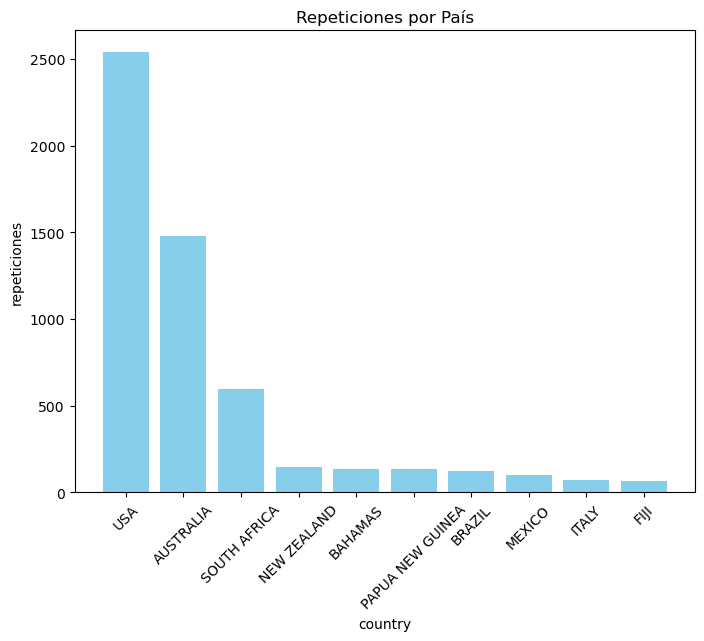

In [83]:
#Diagrama de barras. 

# Crear gráfico de barras
plot.figure(figsize=(8, 6))
plot.bar(country_attack_level['country'], country_attack_level['repeticiones'], color='skyblue')

# Añadir etiquetas y título
plot.xlabel('country')
plot.ylabel('repeticiones')
plot.title('Repeticiones por País')
plot.xticks(rotation=45)

# Mostrar gráfico
plot.show()